In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["axes.edgecolor"] = "k"
plt.rcParams["lines.linewidth"] = 1

In [244]:
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.metrics import r2_score, mean_absolute_error
from typing import List, Tuple, Union

def build_lstm(output_units: int, input_units: int = 128, layer2_units: int = 64, 
               layer3_units: int = 32, loss: Union[str, object] = "mean_absolute_error") -> Sequential:
    """
    Builds and compiles an LSTM model for time-series forecasting.
    
    Parameters:
    - output_units: Number of units in the output layer, defines how many steps to forecast
    - input_units: Number of units in the first LSTM layer (default is 128)
    - layer2_units: Number of units in the second LSTM layer (default is 64)
    - layer3_units: Number of units in the Dense layer (default is 32)
    - loss: Loss function for model compilation (default is "mean_absolute_error")
    
    Returns:
    - Compiled Keras Sequential model
    """
    model = Sequential()
    model.add(LSTM(input_units, activation="tanh", return_sequences=True))  # First LSTM layer
    model.add(LSTM(layer2_units, return_sequences=False))  # Second LSTM layer
    model.add(Dense(layer3_units))  # Dense layer
    model.add(Dense(output_units))  # Output layer
    model.compile(optimizer="adam", loss=loss)  # Compile model
    
    return model

def reshape(list_: List[float]) -> np.ndarray:
    """Converts a list of floats to a NumPy array with dtype 'float32'."""
    return np.array(list_, dtype="float32")

def ts_train_test_split(data: pd.DataFrame, test_size: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits a DataFrame into training and testing sets.
    
    Parameters:
    - data: DataFrame to split
    - test_size: Proportion of the data to use for testing
    
    Returns:
    - Tuple containing training and testing DataFrames
    """
    slice_idx = int(len(data) * (1 - test_size))
    return data[:slice_idx], data[slice_idx:]

# Including the docstring and comments for better understanding

def prepare_data(*data: np.ndarray, lookback: int, forecast: int) -> Tuple[np.ndarray, ...]:
    """
    Prepares time-series data for LSTM or other sequence models.
    
    Parameters:
    - data: One or more ndarrays of time-series data
    - lookback: Number of past time steps to use as input features
    - forecast: Number of future time steps to predict
    
    Returns:
    - Tuple of reshaped input and target ndarrays
    """
    prepared_data = []
    
    # Loop through each data set
    for set_ in data:
        inputs, targets = [], []
        
        # Create input and target sequences
        for idx in range(lookback, len(set_)):
            # Append the past `lookback` points as inputs
            inputs.append(set_[idx-lookback:idx])
            
            # Handle single-point and multi-point forecasts
            if forecast == 1:
                targets.append(set_[idx])
            else:
                # Append the next `forecast` points, or as many as available
                targets.append(set_[idx:idx+forecast] if idx + forecast <= len(set_) else set_[idx:])
        
        # Reshape and append to prepared_data
        inputs = np.array(inputs, dtype="float32")
        targets = np.array(targets, dtype="float32")
        
        # Flatten target array if forecast is 1
        if forecast == 1:
            targets = targets.flatten()
        
        prepared_data.extend([inputs, targets])
    
    return tuple(prepared_data)


def score(y_true: np.ndarray, y_pred: np.ndarray) -> None:
    """
    Computes and prints the R2 and Mean Absolute Error scores for the model.

    Parameters:
    - y_true: The actual values of the data
    - y_pred: The predicted values from the model

    Returns:
    - None
    """
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"R2: {r2:,.5f}, MAE: {mae:,.5f}")

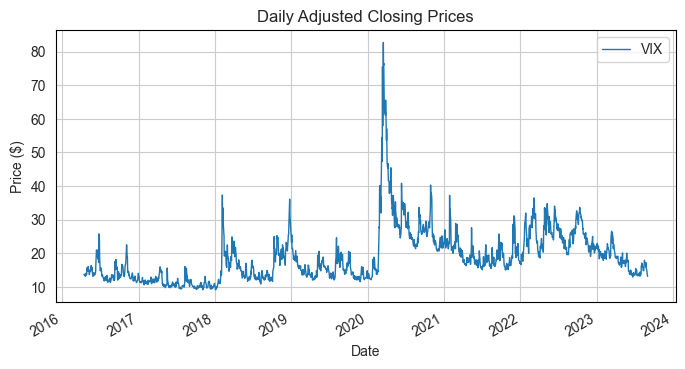

In [271]:
ticker = "^VIX"
start = "2016-04-14"
end = "2023-09-05"

data = yf.download(ticker, start, end, progress=False)[["Adj Close"]]

data.plot(legend=False, figsize=(8, 4))
plt.legend([f"{ticker[1:]}"])
plt.ylabel("Price ($)")
plt.title("Daily Adjusted Closing Prices")
plt.show()

In [245]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

current_data = data.loc[:'2023-01']
future_data = data.loc['2023-01':]

train_set, test_set = ts_train_test_split(current_data, .2)
scaled_train_set, scaled_test_set = scaler.fit_transform(train_set), \
                                    scaler.transform(test_set)

scaled_train_set.shape, scaled_test_set.shape

((1369, 1), (343, 1))

In [246]:
# Use 50 days of previous prices to predict the next day's price.
lookback = 50
forecast = 1

X_train_1, y_train_1, X_test_1, y_test_1 = prepare_data(
    scaled_train_set, 
    scaled_test_set, 
    lookback=lookback, 
    forecast=forecast
)

X_train_1.shape, y_train_1.shape, X_test_1.shape, y_test_1.shape

((1319, 50, 1), (1319,), (293, 50, 1), (293,))

In [282]:
lstm = build_lstm(
    output_units=forecast, 
    input_units=128, 
    layer2_units=64, 
    layer3_units=32, 
    loss="mean_absolute_error"
)

lstm.fit(X_train_1, y_train_1, epochs=2, batch_size=1);

Epoch 1/2
1319/1319 [==============================] - 48s 32ms/step - loss: 0.0285
Epoch 2/2
1319/1319 [==============================] - 42s 32ms/step - loss: 0.0224


In [283]:
lstm_scaled_predictions = lstm.predict(X_test_1)
lstm_predictions = scaler.inverse_transform(lstm_scaled_predictions)

10/10 [==============================] - 3s 52ms/step


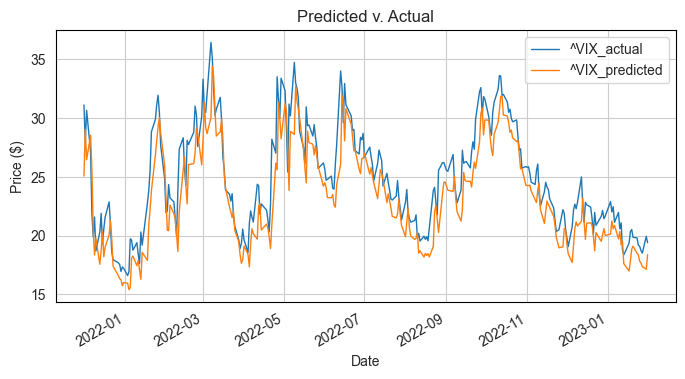

In [284]:
y_test_1_reshaped = y_test_1.reshape(-1, 1)
y_true_1 = scaler.inverse_transform(y_test_1_reshaped)

comparison_df = pd.DataFrame(
    y_true_1, 
    columns=[f"{ticker}_actual"],
    index = test_set[lookback:].index
)

comparison_df[f"{ticker}_predicted"] = lstm_predictions

comparison_df.plot(figsize=(8, 4))
plt.title("Predicted v. Actual")
plt.ylabel("Price ($)")
plt.show()

In [285]:
score(y_true_1, lstm_predictions)

R2: 0.71797, MAE: 1.79052


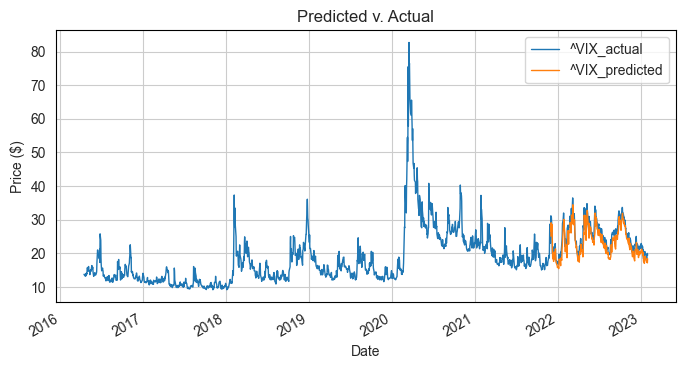

In [288]:
zoom_out = comparison_df[[f"{ticker}_predicted"]].copy()
zoom_out = pd.concat([current_data, zoom_out], axis=1)
zoom_out.rename(columns={'Adj Close': f"{ticker}_actual"}, inplace=True)
zoom_out.plot(figsize=(8, 4))
plt.title("Predicted v. Actual")
plt.ylabel("Price ($)")
plt.show()

NameError: name 'MinMaxScaler' is not defined